In [1]:
# !pip install oolearning --upgrade

In [2]:
import copy
import os
import oolearning as oo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from helpers import column_log, BinaryAucRocScore

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
def create_net_capital(x):
    temp = x.copy()
    temp['net capital'] = temp['capital-gain'] - temp['capital-loss']
    return temp

In [5]:
global_transformations = [
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [6]:
params_dict = dict(
    #penalty=['l1', 'l2'],
    regularization_inverse=[0.001, 0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25, 0.26, 0.27, 0.275, 0.3, 0.5], #regularization_inverse=[0.1, 1, 5, 10, 25, 50, 75],
)

grid = oo.HyperParamsGrid(params_dict=params_dict)
grid.params_grid

,regularization_inverse
0,0.001
1,0.010
2,0.050
3,0.075
4,0.100
5,0.125
6,0.150
7,0.175
8,0.200
9,0.225


In [7]:
hyper_param_object = oo.LogisticClassifierHP(
    # regularization_inverse=
    penalty='l2'
)

In [8]:
model=oo.LogisticClassifier()

In [9]:
repeats = 5
folds = 5

In [10]:
model_cache_directory = 'tuner_Logistic'
resampler_cache_directory = 'tuner_Logistic_resample_cache'

In [11]:
score_list = [oo.AucRocScore(positive_class=positive_class),
              oo.FBetaScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                    positive_class=positive_class),
                            beta=0.5),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                          positive_class=positive_class)),
              oo.PositivePredictiveValueScore(converter=oo.TwoClassThresholdConverter(threshold=0.5,
                                                                                      positive_class=positive_class))]

In [12]:

# define/configure the resampler
resampler = oo.RepeatedCrossValidationResampler(model=model,  # using a Random Forest model
                                             transformations=global_transformations,
                                             scores=[s.clone() for s in score_list],
                                             folds=folds,
                                             repeats=repeats)
# define/configure the ModelTuner
tuner = oo.ModelTuner(resampler=resampler,
                      hyper_param_object=hyper_param_object,
                      model_persistence_manager=oo.LocalCacheManager(cache_directory=model_cache_directory),
                      resampler_persistence_manager=oo.LocalCacheManager(cache_directory=resampler_cache_directory),
                      #parallelization_cores=-1,
                      parallelization_cores=0,
                     )

In [13]:
tuner.tune(data_x=explore.dataset.drop(columns=target_variable),
           data_y=explore.dataset[target_variable],
           params_grid=grid)

In [14]:
params_dict

{'regularization_inverse': [0.001,
  0.01,
  0.05,
  0.075,
  0.1,
  0.125,
  0.15,
  0.175,
  0.2,
  0.225,
  0.23,
  0.235,
  0.24,
  0.245,
  0.25,
  0.26,
  0.27,
  0.275,
  0.3,
  0.5]}

In [15]:
tuner.results.best_hyper_params

{'regularization_inverse': 0.245}

In [16]:
tuner.results.best_model_resampler_object.score_means

{'AUC_ROC': 0.8979669889254202,
 'F_BETA': 0.6896928044426681,
 'sensitivity': 0.5929924579687729,
 'positive_predictive_value': 0.7190590266518271}

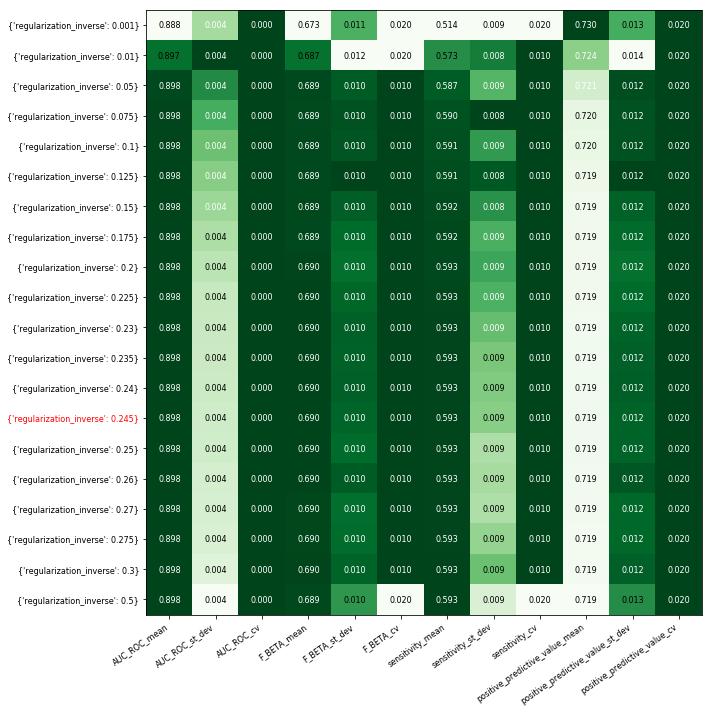

In [17]:
tuner.results.plot_resampled_stats()

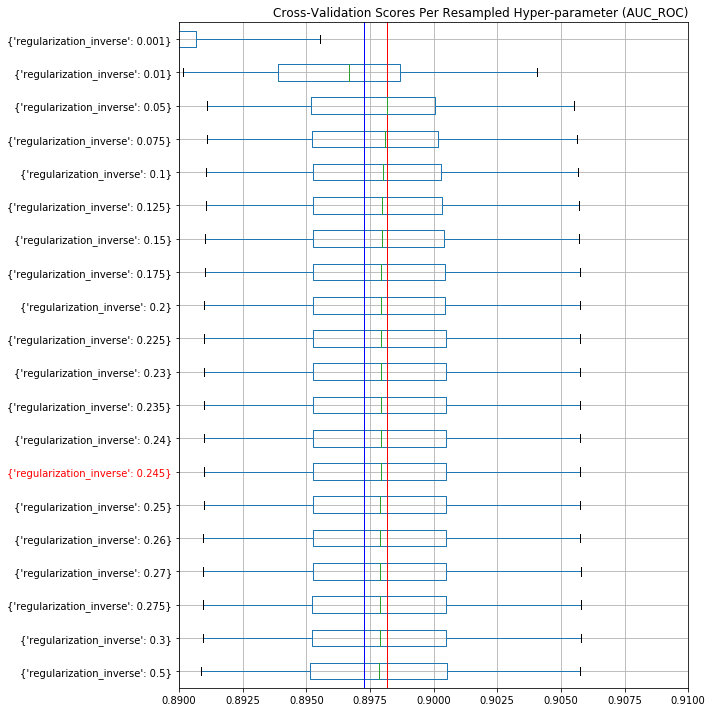

In [18]:
tuner.results.plot_resampled_scores(metric=oo.Metric.AUC_ROC,
                                    x_axis_limits=(0.89, 0.91),
                                    show_one_ste_rule=True
                                   )

In [19]:
params_dict

{'regularization_inverse': [0.001,
  0.01,
  0.05,
  0.075,
  0.1,
  0.125,
  0.15,
  0.175,
  0.2,
  0.225,
  0.23,
  0.235,
  0.24,
  0.245,
  0.25,
  0.26,
  0.27,
  0.275,
  0.3,
  0.5]}

In [20]:
tuner.results.best_hyper_params

{'regularization_inverse': 0.245}

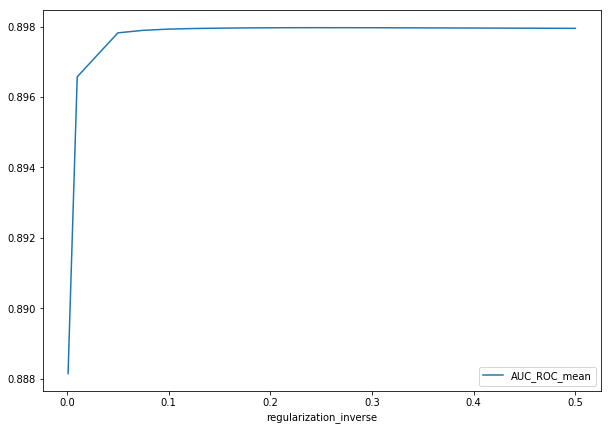

In [22]:
tuner.results.plot_hyper_params_profile(metric=oo.Metric.AUC_ROC,
                                        x_axis='regularization_inverse',
                                        #line='penalty',
#                                        grid='n_estimators'
                                       )

In [ ]:
assert False

# Retrain on Full Training

In [23]:
final_hyper_param_object = oo.LogisticClassifierHP(
                                                   penalty='l2',
                                                   regularization_inverse=0.245
                                                  )

final_model = oo.LogisticClassifier()
final_transformations = [
                         # kaggle test file has white space around values
                         oo.StatelessColumnTransformer(columns=explore.categoric_features,
                                                       custom_function=lambda x: x.str.strip()),
                         oo.ImputationTransformer(),
                         oo.StatelessColumnTransformer(columns=['capital-gain', 'capital-loss'],
                                                       custom_function=column_log),
                         oo.StatelessTransformer(custom_function=create_net_capital),
                         oo.CenterScaleTransformer(),
                         oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)
]

In [24]:
# use the ideal threshold for the evaluator in order to view ROC
evaluator = oo.TwoClassProbabilityEvaluator(converter=
                    oo.TwoClassThresholdConverter(positive_class=positive_class))

trainer = oo.ModelTrainer(model=final_model.clone(),
                          model_transformations=[t.clone() for t in final_transformations],
                          splitter=None,  # don't split, train on all data
                          evaluator=evaluator,
                          scores=[s.clone() for s in score_list])
trainer.train(data=explore.dataset, target_variable=target_variable, hyper_params=final_hyper_param_object.clone())

trainer.training_evaluator.all_quality_metrics

{'AUC ROC': 0.8991649012181953,
 'AUC Precision/Recall': 0.7461680744416082,
 'Kappa': 0.5510381352140985,
 'F1 Score': 0.6516788035775376,
 'Two-Class Accuracy': 0.8423997169519261,
 'Error Rate': 0.15760028304807394,
 'True Positive Rate': 0.5948429693076374,
 'True Negative Rate': 0.9239724819192098,
 'False Positive Rate': 0.07602751808079027,
 'False Negative Rate': 0.4051570306923626,
 'Positive Predictive Value': 0.720523073597752,
 'Negative Predictive Value': 0.8737523978981901,
 'Prevalence': 0.2478439697492371,
 'No Information Rate': 0.7521560302507629,
 'Total Observations': 45222}

In [25]:
trainer.training_scores[0].value

0.8991649012181953

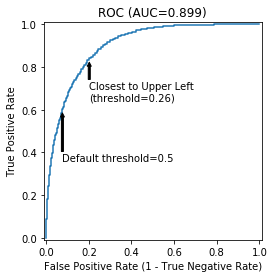

In [26]:
trainer.training_evaluator.plot_roc_curve()

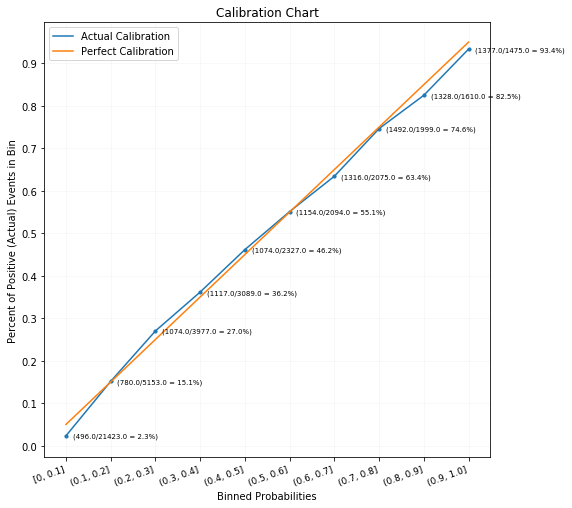

In [27]:
trainer.training_evaluator.plot_calibration()

In [ ]:
csv_file = '../test_census.csv'
test_dataset = pd.read_csv(csv_file)
test_dataset.shape

In [ ]:
test_dataset.head(100)

In [ ]:
indexes = test_dataset['Unnamed: 0']

predictions = trainer.predict(test_dataset.drop(columns='Unnamed: 0'))
predictions.head(10)

# Results

## 1)

Kaggle Public: ``

File: `submission_x_Logistic.csv`

Parameters: 

```

```

Originally had Mean Resampler Results of:

```

```

In [ ]:
""